In [2]:
# while the other humongous error of a SVM is running... at least it  use only one core so here we go


In [3]:
# let's start again with linear SVC and see how we are overfitting


In [80]:
# helpers
def build_feature_matrix(df, vocab, embeddings, mode='avg'):
    X = np.zeros((df.shape[0], embeddings.shape[1]))
    for i, tweet in enumerate(df['tweet']):
        words = tweet.split()
        for word in words:
            if word in vocab:
                X[i] += embeddings[vocab[word]]
        if mode == 'avg':
            X[i] /= len(words)
        elif mode == 'sum':
            pass
        else:
            raise ValueError('Unknown mode: {}'.format(mode))
    return X
    
def load_train_data(path_pos='data/twitter-datasets/train_pos_full.txt', path_neg='data/twitter-datasets/train_neg_full.txt'):
    # Load data, txt as csv
    #data_path = 'data/twitter-datasets/'
    df_train_pos = pd.read_csv(path_pos, sep = '\t', names = ['tweet'])
    df_train_pos['label'] = 1
    df_train_neg = pd.read_csv(path_neg, sep = '\t', names = ['tweet'], on_bad_lines='skip')
    df_train_neg['label'] = 0
    df_train = pd.concat([df_train_pos, df_train_neg])
    print('Train set: ', df_train.shape)
    print('Train set positives: ', df_train_pos.shape)
    print('Train set negatives: ', df_train_neg.shape)
    return df_train   

def load_test_data():
    # Load test data: id, tweet for each row
    data_path = 'data/twitter-datasets/'
    df_test = pd.read_csv(data_path + 'test_data.txt', header=None, names=['line'], sep='\t')
    # Extract id and tweet, limit split by 1 so we don't split the tweet (this is v0, at least we keep it intact)
    df_test['id'] = df_test['line'].apply(lambda x: x.split(',',1)[0]) 
    df_test['tweet'] = df_test['line'].apply(lambda x: x.split(',',1)[1])
    df_test = df_test.drop('line', axis=1)
    return df_test

def predict_test_data(X_test, classifier, filename='submission.csv'):
    # Predict test data and save to csv
    y_pred = classifier.predict(X_test)
    df_test['Prediction'] = y_pred
    df_test.rename(columns={'id': 'Id'}, inplace=True)
    df_test['Prediction'] = df_test['Prediction'].apply(lambda x: -1 if x == 0 else x)
    df_test.to_csv(filename, columns=['Id', 'Prediction'], index=False)
    return df_test
    
def predict_test_data_pipeline(df_test, pipe, filename='submission.csv'):
    # Predict test data and save to csv
    y_pred = pipe.predict(df_test['tweet'])
    df_test['Prediction'] = y_pred
    df_test.rename(columns={'id': 'Id'}, inplace=True)
    df_test['Prediction'] = df_test['Prediction'].apply(lambda x: -1 if x == 0 else x)
    df_test.to_csv(filename, columns=['Id', 'Prediction'], index=False)
    return df_test

def train_test(clf, X_train, y_train, X_eval=None, y_eval=None, cv=None):
    from sklearn.metrics import accuracy_score, f1_score
    if X_eval is None:
        from sklearn.model_selection import train_test_split
        X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2)
    if cv is not None:
        from sklearn.model_selection import cross_val_score
        scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1, shuffle=True)
        print('Cross validation Accuracy Scores: ', scores)
        print('Cross validation mean score: ', scores.mean())
        print('Cross validation std score: ', scores.std())
        clf.fit(X_train, y_train)
        return clf
    clf.fit(X_train, y_train)
    print('Training set size: ', X_train.shape, ' Evaluation set size: ', X_eval.shape)
    print('Metrics on evaluation set: ')
    test(clf, X_eval, y_eval)
    print('Metrics on training set to check overfitting/triviality of model: ')
    test(clf, X_train, y_train)
    from sklearn.metrics import confusion_matrix
    print('Confusion matrix: ')
    print(confusion_matrix(y_eval, clf.predict(X_eval)))
    return clf

def test(clf, X_eval, y_eval):
    from sklearn.metrics import accuracy_score, f1_score
    y_pred = clf.predict(X_eval)
    print('Accuracy: ', accuracy_score(y_eval, y_pred))
    print('F1 score: ', f1_score(y_eval, y_pred))
    return y_pred


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline


In [6]:
# Load data, lets work on partial data for now, we'll come back to this later
df_train = load_train_data(path_pos='data/twitter-datasets/train_pos.txt', path_neg='data/twitter-datasets/train_neg.txt')
# Load vectorization and classifier obtained from the previous notebook as a reference
with open('data/out/trained/tfidf_vectorizer-linSVC-pipeline-v2_4.pickle', 'rb') as f:
    pipe = pickle.load(f)

# we know that this achieves acc: 0.848	f1: 0.850 and runs in less than 3min on full data from scratch
# let's train a linear SVC on the partial data and see how it performs so we can compare and iterate
svm = LinearSVC()
vec_pipe = pipe.steps[0][1]
svm_pipe = pipe.steps[1][1]
print(vec_pipe, svm_pipe)

Train set:  (196970, 2)
Train set positives:  (97902, 2)
Train set negatives:  (99068, 2)
TfidfVectorizer(binary=True, min_df=3, ngram_range=(1, 4)) LinearSVC()


In [7]:
# check svm_pipe performance on partial data, don't even modify the vectorizer
X_train, X_eval, y_train, y_eval = train_test_split(df_train['tweet'], df_train['label'], test_size=0.2)
X_train = vec_pipe.transform(X_train)
X_eval = vec_pipe.transform(X_eval)

In [8]:
# Let's play around with the following:
# scale the vectors
# use -1/1 instead of 0/1
# check overfitting of svm, force reduction in dimensionality and reduce C
linsvc = LinearSVC()
linsvc = train_test(linsvc, X_train, y_train, X_eval, y_eval)

Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
Metrics on evaluation set: 
Accuracy:  0.8346956389297863
F1 score:  0.8363983519244297
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.997106158298218
F1 score:  0.997089943713385
Confusion matrix: 
[[78999   261]
 [  195 78121]]


In [10]:
# So we dont fit exactly 100% of the training data but very close.
# let's scale the vectors and see if we can improve the performance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_eval_scaled = scaler.transform(X_eval)
linsvc = LinearSVC()
#linsvc = train_test(linsvc, X_train_scaled, y_train, X_eval_scaled, y_eval)

# 1min
# Accuracy:  0.7852718688125095
# F1 score:  0.7872324370551098
# /Users/jacopoferro/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
#   warnings.warn(

In [11]:
# use -1/1
y_train_1 = y_train.apply(lambda x: -1 if x == 0 else x)
y_eval_1 = y_eval.apply(lambda x: -1 if x == 0 else x)
linsvc = LinearSVC()
#linsvc = train_test(linsvc, X_train_scaled, y_train_1, X_eval_scaled, y_eval_1)

# 1min
# Accuracy:  0.7848657155912068
# F1 score:  0.7855461929704699
# /Users/jacopoferro/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
#   warnings.warn(

In [12]:
# use -1/1 and without scale
linsvc = LinearSVC()
linsvc = train_test(linsvc, X_train, y_train_1, X_eval, y_eval_1)

Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
Metrics on evaluation set: 
Accuracy:  0.8346956389297863
F1 score:  0.8363983519244297
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.997106158298218
F1 score:  0.997089943713385
Confusion matrix: 
[[78999   261]
 [  195 78121]]


In [13]:
# reduce dimensionality, check initial dimensionality
print(X_train.shape)

(157576, 3018685)


In [14]:
# reduce dimensionality
from sklearn.decomposition import TruncatedSVD # works with sparse matrices and in this context this is LSA
# let's use default = 2 just for visualization purposes
svd = TruncatedSVD(n_components=2)
X_train_reduced_2 = svd.fit_transform(X_train)

(157576, 2)


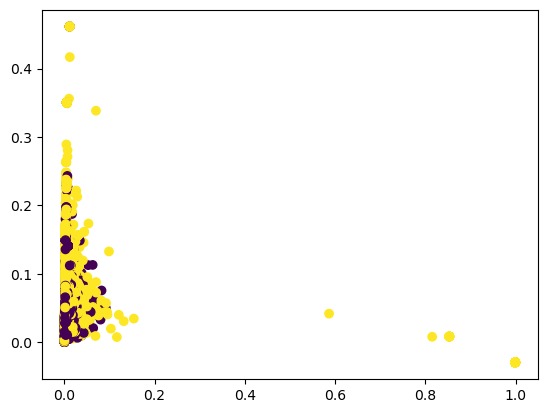

In [15]:
# visualize the data in 2D
print(X_train_reduced_2.shape)
plt.scatter(X_train_reduced_2[:, 0], X_train_reduced_2[:, 1], c=y_train_1)

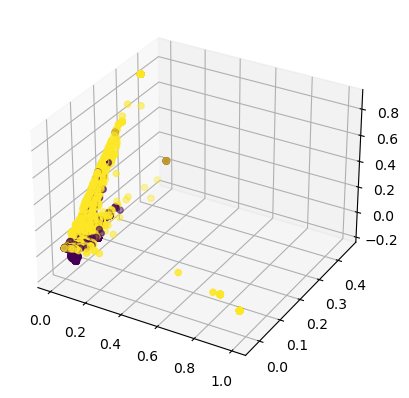

In [16]:
# now in 3d
from mpl_toolkits.mplot3d import Axes3D
svd = TruncatedSVD(n_components=3)
X_train_reduced_3 = svd.fit_transform(X_train)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_reduced_3[:, 0], X_train_reduced_3[:, 1], X_train_reduced_3[:, 2], c=y_train_1)


In [17]:
# This was actually useful to see that there might be quite a lot of outliers in the data
# Let's try to reduce the dimensionality to 100 and see if we can improve the performance
svd = TruncatedSVD(n_components=100)
X_train_reduced_100 = svd.fit_transform(X_train)
X_eval_reduced_100 = svd.transform(X_eval)
linsvc = LinearSVC()
#linsvc = train_test(linsvc, X_train_reduced_100, y_train_1, X_eval_reduced_100, y_eval_1)

# 1min - didn't comment out this because it's useful to create the reduced one
# Accuracy:  0.7165812052596842
# F1 score:  0.714924039320822

In [18]:
# honestly, from 3018685 dimensions to 100 and we are still able to achieve 0.71 accuracy and 0.71 f1 score
# Is GOOD. This shows how important the vectoriazion and features are in the first place.
# We are basically creating our own embeddings from the n-grams and tfidf scores
linsvc = LinearSVC(C=0.1)
linsvc = train_test(linsvc, X_train_reduced_100, y_train_1, X_eval_reduced_100, y_eval_1)
#print('On train data:')
#train_test(linsvc, X_train_reduced_100, y_train_1, X_train_reduced_100, y_train_1)

Training set size:  (157576, 100)  Evaluation set size:  (39394, 100)
Metrics on evaluation set: 
Accuracy:  0.7166573589886784
F1 score:  0.7143807574206756
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.715584860638676
F1 score:  0.713664155789393
Confusion matrix: 
[[56908 22352]
 [22465 55851]]
On train data:
Training set size:  (157576, 100)  Evaluation set size:  (157576, 100)
Metrics on evaluation set: 
Accuracy:  0.715584860638676
F1 score:  0.713664155789393
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.715584860638676
F1 score:  0.713664155789393
Confusion matrix: 
[[56908 22352]
 [22465 55851]]


LinearSVC(C=0.1)

In [19]:
linsvc = LinearSVC(C=0.01)
linsvc = train_test(linsvc, X_train_reduced_100, y_train_1, X_eval_reduced_100, y_eval_1)
#train_test(linsvc, X_train_reduced_100, y_train_1, X_train_reduced_100, y_train_1)

Training set size:  (157576, 100)  Evaluation set size:  (39394, 100)
Metrics on evaluation set: 
Accuracy:  0.7074427577803727
F1 score:  0.7036589442287419
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.7065542976087729
F1 score:  0.7037416709379806
Confusion matrix: 
[[56416 22844]
 [23396 54920]]
Training set size:  (157576, 100)  Evaluation set size:  (157576, 100)
Metrics on evaluation set: 
Accuracy:  0.7065542976087729
F1 score:  0.7037416709379806
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.7065542976087729
F1 score:  0.7037416709379806
Confusion matrix: 
[[56416 22844]
 [23396 54920]]


LinearSVC(C=0.01)

In [20]:
# This is great, we now don't overfit at all.
# let's keep the dimensionality high but reduce C
linsvc = LinearSVC(C=0.1)
linsvc = train_test(linsvc, X_train, y_train_1, X_eval, y_eval_1)
#print('On train data:')
#train_test(linsvc, X_train, y_train_1, X_train, y_train_1)

Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
Metrics on evaluation set: 
Accuracy:  0.8256079606031376
F1 score:  0.8282156431286256
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.9027834187947403
F1 score:  0.9037527566080056
Confusion matrix: 
[[70335  8925]
 [ 6394 71922]]
On train data:
Training set size:  (157576, 3018685)  Evaluation set size:  (157576, 3018685)
Metrics on evaluation set: 
Accuracy:  0.9027834187947403
F1 score:  0.9037527566080056
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.9027834187947403
F1 score:  0.9037527566080056
Confusion matrix: 
[[70335  8925]
 [ 6394 71922]]


LinearSVC(C=0.1)

In [21]:
linsvc = LinearSVC(C=0.01)
linsvc = train_test(linsvc, X_train, y_train_1, X_eval, y_eval_1)
print('On train data:')
train_test(linsvc, X_train, y_train_1, X_train, y_train_1)

Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
Metrics on evaluation set: 
Accuracy:  0.7774788038787632
F1 score:  0.7792717933222542
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.7992460780829568
F1 score:  0.8008110116236604
Confusion matrix: 
[[62352 16908]
 [14726 63590]]
On train data:
Training set size:  (157576, 3018685)  Evaluation set size:  (157576, 3018685)
Metrics on evaluation set: 
Accuracy:  0.7992460780829568
F1 score:  0.8008110116236604
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.7992460780829568
F1 score:  0.8008110116236604
Confusion matrix: 
[[62352 16908]
 [14726 63590]]


LinearSVC(C=0.01)

In [22]:
# Let's use a kernel = linear SVC and see why it was so horribly slow
# svc = SVC(kernel='linear')
# svc = train_test(svc, X_train, y_train_1, X_eval, y_eval_1)
# annoyingly slow. we also use this ONLY because we wanted to use the 
# probability estimates in a boosted ensemble method

In [23]:
# svc = SVC(kernel='linear')
# svc = train_test(svc, X_train_reduced_100, y_train_1, X_eval_reduced_100, y_eval_1)
# # even on reduced dimensionality it is slow. over 2min 40s and counting

In [24]:
# So, for now linear SVC is sweet and we also learned how using reduced C and/or dimensionality reduction
# can help us avoid overfitting while still achieving good performance
# We originally considered the slower SVC(linear) just to have access to the probability estimates to then use them
# in a boosted ensemble method. Let's rewind a bit and go back to trees and boosting

In [25]:
# # tree
# from sklearn.tree import DecisionTreeClassifier
# tree = DecisionTreeClassifier()
# tree = train_test(tree, X_train, y_train_1, X_eval, y_eval_1)
# print('On train data:')
# train_test(tree, X_train, y_train_1, X_train, y_train_1)

#18+ min
# Accuracy:  0.7467888510940752
# F1 score:  0.7470521110688474
# On train data: ... I stopped it, it was re-training again, I modifi train_test function so it doesnt 

In [26]:
# I have high hopes for my tree buddies, let's improve them
# let's focus on the balance between speed and performance
# overall the goal is to have many weak learners that are not overfitting and that are fast to train
lil_tree = DecisionTreeClassifier(
    max_depth=8,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    splitter='best'
)
lil_tree = train_test(lil_tree, X_train, y_train_1, X_eval, y_eval_1)
#print('On train data:')
#train_test(lil_tree, X_train, y_train_1, X_train, y_train_1)

Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
Metrics on evaluation set: 
Accuracy:  0.5043915317053358
F1 score:  0.009135200974421435
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.5047532619180586
F1 score:  0.009619655570643553
Confusion matrix: 
[[79158   102]
 [77937   379]]
On train data:
Training set size:  (157576, 3018685)  Evaluation set size:  (157576, 3018685)
Metrics on evaluation set: 
Accuracy:  0.5083007564603746
F1 score:  0.03698916177786617
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.5083007564603746
F1 score:  0.03698916177786617
Confusion matrix: 
[[78608   652]
 [76828  1488]]


DecisionTreeClassifier(max_depth=8, max_features='sqrt')

In [28]:
# instead of reducing the max_features inside the tree let's reduce the dimensionality before
lil_tree = DecisionTreeClassifier(
    max_depth=8,
    min_samples_leaf=1,
    min_samples_split=2,
    splitter='best',
    max_features=None,
)
lil_tree = train_test(lil_tree, X_train_reduced_100, y_train_1, X_eval_reduced_100, y_eval_1)
#print('On train data:')
#train_test(lil_tree, X_train_reduced_100, y_train_1, X_train_reduced_100, y_train_1)


Training set size:  (157576, 100)  Evaluation set size:  (39394, 100)
Metrics on evaluation set: 
Accuracy:  0.6891150936690866
F1 score:  0.7035127218147046
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.6996750774229578
F1 score:  0.7139437607292245
Confusion matrix: 
[[51196 28064]
 [19260 59056]]


In [34]:
# Great, now we have something similar to the linear SVC but with more flexbility that we can
# boost reliably. Using 1000 features should probably work even better. Let's try to force the features
# to 100 instead and compare
lil_tree = DecisionTreeClassifier(
    max_depth=8,
    min_samples_leaf=1,
    min_samples_split=2,
    splitter='best',
    max_features=100,
)
lil_tree = train_test(lil_tree, X_train, y_train_1, X_eval, y_eval_1)

Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
Metrics on evaluation set: 
Accuracy:  0.5028430725491192
F1 score:  0.0001021085413794864
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.5031223028887648
F1 score:  0.0005106209150326798
Confusion matrix: 
[[79260     0]
 [78296    20]]


In [38]:
# So by performing the dimensionality reduction before the tree we are able to achieve 
# still decent speed in absolute values but muuuuuch better performance 
# let's use the best random splits instead
lil_tree = DecisionTreeClassifier(
    max_depth=8,
    min_samples_leaf=1,
    min_samples_split=2,
    splitter='random',
    max_features=None,
)
lil_tree = train_test(lil_tree, X_train_reduced_100, y_train_1, X_eval_reduced_100, y_eval_1)

Training set size:  (157576, 100)  Evaluation set size:  (39394, 100)
Metrics on evaluation set: 
Accuracy:  0.6417220896583236
F1 score:  0.6969553828316228
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.646221505813068
F1 score:  0.7001640446416566
Confusion matrix: 
[[36740 42520]
 [13227 65089]]


In [39]:
# Now that we have good performance we can actually go back and run the tree on the full dataset
# but with the random split, let's see if it overfits
tree = DecisionTreeClassifier(
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    splitter='random',
    max_features=None,
)
#tree = train_test(tree, X_train, y_train_1, X_eval, y_eval_1)

# 11min 24s
# Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
# Metrics on evaluation set: 
# Accuracy:  0.7567396050159922
# F1 score:  0.758169934640523
# Metrics on training set to check overfitting/triviality of model: 
# Accuracy:  0.9994478854647916
# F1 score:  0.9994445260274671
# Confusion matrix: 
# [[79221    39]
#  [   48 78268]]

Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
Metrics on evaluation set: 
Accuracy:  0.7567396050159922
F1 score:  0.758169934640523
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.9994478854647916
F1 score:  0.9994445260274671
Confusion matrix: 
[[79221    39]
 [   48 78268]]


In [42]:
# It's still taking 10+minutes and not seconds so using the full 3018685 features is annoying.
# Let's use 'sqrt' instead of None for max_features
# I still finished runnig the cell above, at least we definitely know it overfits :)
# Let's now iterate
lil_tree = DecisionTreeClassifier(
    max_depth=3,
    min_samples_leaf=1,
    min_samples_split=2,
    splitter='best',
    max_features=None,
)
#lil_tree = train_test(lil_tree, X_train, y_train_1, X_eval, y_eval_1)

# 11min 40s ... I'm an idiot I left 'tree' as the name of the variable above but ok
# Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
# Metrics on evaluation set: 
# Accuracy:  0.7572726811189521
# F1 score:  0.7580343134774026
# Metrics on training set to check overfitting/triviality of model: 
# Accuracy:  0.9994478854647916
# F1 score:  0.9994445260274671
# Confusion matrix: 
# [[79221    39]
#  [   48 78268]]

# On lil tree:
# 2minn 46s
# Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
# Metrics on evaluation set: 
# Accuracy:  0.65862821749505
# F1 score:  0.679626453211359
# Metrics on training set to check overfitting/triviality of model: 
# Accuracy:  0.6573462963903133
# F1 score:  0.6777439570277529
# Confusion matrix: 
# [[46804 32456]
#  [21538 56778]]

Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
Metrics on evaluation set: 
Accuracy:  0.65862821749505
F1 score:  0.679626453211359
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.6573462963903133
F1 score:  0.6777439570277529
Confusion matrix: 
[[46804 32456]
 [21538 56778]]


In [46]:
X_train[0]

<1x3018685 sparse matrix of type '<class 'numpy.float64'>'
	with 33 stored elements in Compressed Sparse Row format>

In [47]:
X_train_reduced_100[0]

array([ 4.82956073e-03,  3.78585652e-02, -2.05811970e-02, -4.59885126e-04,
       -6.40908012e-03, -1.19870832e-02, -2.34761303e-02,  2.34429821e-02,
       -1.01778152e-02, -1.34612603e-02,  5.11974571e-02,  1.18305089e-02,
       -2.24450418e-02,  6.65029219e-04, -4.79984513e-03, -2.09496152e-02,
        5.15623137e-03, -1.16515598e-02, -7.42660751e-03, -8.15070116e-03,
       -6.01704438e-03, -1.14769188e-02, -1.34180513e-02, -5.22961892e-03,
        6.39743076e-03,  1.44645025e-02, -2.17888124e-03, -3.16140089e-02,
       -1.46238941e-02,  1.51265829e-02,  5.21486797e-03,  1.79515303e-03,
        1.46692638e-03,  1.53259584e-03, -3.56023714e-03, -3.20024449e-03,
        1.96275832e-04,  2.40189394e-02, -3.76458630e-03, -4.86841170e-03,
       -7.85747991e-03, -6.97950465e-03,  4.43853865e-03, -3.57856831e-03,
       -6.66529319e-03,  8.31558217e-03,  6.57715279e-03,  6.25310762e-03,
        5.72701299e-03,  1.44418422e-02, -4.55826779e-03, -9.04544968e-04,
        3.74043779e-02, -

In [48]:
X_train[1]

<1x3018685 sparse matrix of type '<class 'numpy.float64'>'
	with 19 stored elements in Compressed Sparse Row format>

In [56]:
print(X_train[1])

  (0, 147880)	0.06240301293157544
  (0, 178666)	0.2678488907719721
  (0, 999927)	0.12358068897593906
  (0, 1000906)	0.26899131038778346
  (0, 1000910)	0.3066688251831143
  (0, 1402170)	0.13782596329911015
  (0, 1403093)	0.2357540781855153
  (0, 1940020)	0.23841034881558804
  (0, 2146399)	0.12949326121321342
  (0, 2148079)	0.21137348915830573
  (0, 2166174)	0.23601922773985629
  (0, 2166186)	0.3101021152949708
  (0, 2166187)	0.3101021152949708
  (0, 2422364)	0.14591976332561654
  (0, 2423236)	0.30369477401166345
  (0, 2549884)	0.14354188364555356
  (0, 2549950)	0.2117740008411735
  (0, 2549978)	0.31913275562643445
  (0, 2920751)	0.1448198699610625


In [65]:
# Great, now we know that lil tree can't fully fit the data.
# note also that lil_tree is slow: 'best' split + no cap on max_features is slow
# and note how nb of features is literally more than the nb of samples so we should really cap them
# since we waited for the training lets save the big slow tree

# also, notice this: we actually fit the training data better than the linear SVC
# here the problem is just a matter of regularizing and simlifying the model to avoid overfit.
# save to pickle
import pickle
with open('data/out/trained/big_overfit_tree_cut_data_tfidf_vec.pkl', 'wb') as f:
    pickle.dump(tree, f)

# load from pickle
with open('data/out/trained/big_overfit_tree_cut_data_tfidf_vec.pkl', 'rb') as f:
    tree_ = pickle.load(f)

# print tree stats
print('big tree:')
print('tree node number: ', tree_.tree_.node_count)
print('tree max depth: ', tree_.tree_.max_depth)
print('tree leaves number: ', tree_.tree_.n_leaves)
print('Tree Params: ', tree_.get_params())
print('Tree score: ', tree_.score(X_eval, y_eval_1))

# save lil tree
with open('data/out/trained/lil_tree_cut_data_tfidf_vec.pkl', 'wb') as f:
    pickle.dump(lil_tree, f)

# load lil tree
with open('data/out/trained/lil_tree_cut_data_tfidf_vec.pkl', 'rb') as f:
    lil_tree_ = pickle.load(f)

# print lil tree stats
print('lil tree:')
print('tree node number: ', lil_tree_.tree_.node_count)
print('tree max depth: ', lil_tree_.tree_.max_depth)
print('tree leaves number: ', lil_tree_.tree_.n_leaves)
print('Tree Params: ', lil_tree_.get_params())
print('Tree score: ', lil_tree_.score(X_eval, y_eval_1))



big tree:
tree node number:  45859
tree max depth:  1047
tree leaves number:  22930
Tree Params:  {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'random'}
Tree score:  0.7572726811189521
lil tree:
tree node number:  15
tree max depth:  3
tree leaves number:  8
Tree Params:  {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
Tree score:  0.65862821749505


This is actually crazy
lil tree uses 15 nodes and 8 leaves and is still able to fit the data??? how?
I'm missing something here or lil tree is just a miracle
or maybe it's just how good the vectorizer is and its impact??

In [68]:
# let's make more lil trees
lil_tree = DecisionTreeClassifier(
    max_depth=3,
    min_samples_leaf=1,
    min_samples_split=2,
    splitter='random',
    max_features='sqrt',
)
lil_tree = train_test(lil_tree, X_train, y_train_1, X_eval, y_eval_1)

Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
Metrics on evaluation set: 
Accuracy:  0.5033507640757475
F1 score:  0.002345622354800877
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.5038203787378789
F1 score:  0.003796952245043576
Confusion matrix: 
[[79241    19]
 [78167   149]]


In [70]:
# let's make more lil trees
lil_tree = DecisionTreeClassifier(
    max_depth=3,
    min_samples_leaf=1,
    min_samples_split=2,
    splitter='best',
    max_features='sqrt',
)
lil_tree = train_test(lil_tree, X_train, y_train_1, X_eval, y_eval_1)

Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
Metrics on evaluation set: 
Accuracy:  0.5030461491597705
F1 score:  0.0010205643720977702
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.5032999949230847
F1 score:  0.001301518438177874
Confusion matrix: 
[[79257     3]
 [78265    51]]


In [71]:
# we are clearly picking the features super badly, maybe we can sort them by importance
#... no, actually let's just build a lil forest and see
# let's give our lil tree some friends <3
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(
    n_estimators=10,
    max_depth=3,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features='sqrt',
)
forest = train_test(forest, X_train, y_train_1, X_eval, y_eval_1)



Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
Metrics on evaluation set: 
Accuracy:  0.5066761435751638
F1 score:  0.01729368932038835
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.5079136416713205
F1 score:  0.020959331321574223
Confusion matrix: 
[[79205    55]
 [77486   830]]


In [72]:
forest = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features='sqrt',
)
forest = train_test(forest, X_train, y_train_1, X_eval, y_eval_1)

Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
Metrics on evaluation set: 
Accuracy:  0.5985683098949078
F1 score:  0.419286133960047
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.5999898461694674
F1 score:  0.4220217136150235
Confusion matrix: 
[[71532  7728]
 [55304 23012]]


In [74]:
forest = RandomForestClassifier(
    n_estimators=250,
    max_depth=3,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features='sqrt',
    n_jobs=-1,
)
forest = train_test(forest, X_train, y_train_1, X_eval, y_eval_1)

Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
Metrics on evaluation set: 
Accuracy:  0.5669137432096258
F1 score:  0.2584430825400965
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.5688810478753109
F1 score:  0.26259687818856786
Confusion matrix: 
[[77546  1714]
 [66220 12096]]


In [81]:
# let's slowly increase complexity
forest = RandomForestClassifier(
    n_estimators=100,
    max_depth=4,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features='sqrt',
    n_jobs=-1,
)
forest = train_test(forest, X_train, y_train_1, X_eval, y_eval_1)

Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
Metrics on evaluation set: 
Accuracy:  0.6033152256688836
F1 score:  0.3967573827446439
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.6044511854597147
F1 score:  0.3986995571934361
Confusion matrix: 
[[18628  1180]
 [14447  5139]]


In [93]:
# Notice the confusion matrix:
# [[18628  1180]
#  [14447  5139]]
# plot false positives and false negatives
print('False positives: ', y_eval_1[forest.predict(X_eval) > y_eval_1].shape[0])
print('False negatives: ', y_eval_1[forest.predict(X_eval) < y_eval_1].shape[0])
print('True pos+True negatives: ', y_eval_1[forest.predict(X_eval) == y_eval_1].shape[0])
# a lot of false positives, we could manually adjust, but let's just keep track for now



False positives:  1180
False negatives:  14447
True pos+True negatives:  23767


In [94]:

forest = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features='sqrt',
    n_jobs=-1,
)
forest = train_test(forest, X_train, y_train_1, X_eval, y_eval_1)

Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
Metrics on evaluation set: 
Accuracy:  0.6118190587399096
F1 score:  0.42515600330802195
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.6124790577245266
F1 score:  0.4254530400255923
Confusion matrix: 
[[18447  1361]
 [13931  5655]]


In [95]:
# let's slowly increase complexity
forest = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features='sqrt',
    n_jobs=-1,
)
forest = train_test(forest, X_train, y_train_1, X_eval, y_eval_1)

Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
Metrics on evaluation set: 
Accuracy:  0.6416713205056608
F1 score:  0.5234622915400715
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.646481697720465
F1 score:  0.5299785686562379
Confusion matrix: 
[[17525  2283]
 [11833  7753]]


In [96]:
forest = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features='sqrt',
    n_jobs=-1,
)
forest = train_test(forest, X_train, y_train_1, X_eval, y_eval_1)

Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
Metrics on evaluation set: 
Accuracy:  0.6695435853175611
F1 score:  0.5861257709671266
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.679672031273798
F1 score:  0.5998604791273604
Confusion matrix: 
[[17158  2650]
 [10368  9218]]


In [97]:
# let's now use the 100 features extracted
forest = RandomForestClassifier(
    n_estimators=10,
    max_depth=3,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features=None,
    n_jobs=-1,
)
forest = train_test(forest, X_train_reduced_100, y_train_1, X_eval_reduced_100, y_eval_1)

Training set size:  (157576, 100)  Evaluation set size:  (39394, 100)
Metrics on evaluation set: 
Accuracy:  0.6522059196832005
F1 score:  0.6838352371062651
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.6507716911204752
F1 score:  0.6823518546310942
Confusion matrix: 
[[10876  8932]
 [ 4769 14817]]


In [98]:

forest = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features=None,
    n_jobs=-1,
)
forest = train_test(forest, X_train_reduced_100, y_train_1, X_eval_reduced_100, y_eval_1)

Training set size:  (157576, 100)  Evaluation set size:  (39394, 100)
Metrics on evaluation set: 
Accuracy:  0.6522313042595319
F1 score:  0.6840988747463569
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.6510763060364523
F1 score:  0.6828705572923276
Confusion matrix: 
[[10860  8948]
 [ 4752 14834]]


In [99]:
# let's now use the 100 features extracted
forest = RandomForestClassifier(
    n_estimators=5,
    max_depth=5,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features=None,
    n_jobs=-1,
)
forest = train_test(forest, X_train_reduced_100, y_train_1, X_eval_reduced_100, y_eval_1)

Training set size:  (157576, 100)  Evaluation set size:  (39394, 100)
Metrics on evaluation set: 
Accuracy:  0.675026653805148
F1 score:  0.708886665453884
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.6765941513936132
F1 score:  0.7101211028378679
Confusion matrix: 
[[11005  8803]
 [ 3999 15587]]


In [100]:
# let's now use the 100 features extracted
forest = RandomForestClassifier(
    n_estimators=5,
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features=None,
    n_jobs=-1,
)
forest = train_test(forest, X_train_reduced_100, y_train_1, X_eval_reduced_100, y_eval_1)

Training set size:  (157576, 100)  Evaluation set size:  (39394, 100)
Metrics on evaluation set: 
Accuracy:  0.7126719805046454
F1 score:  0.7293723849372384
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.7410773214195056
F1 score:  0.7560363075377605
Confusion matrix: 
[[12822  6986]
 [ 4333 15253]]


In [ ]:
# we are just now starting to overfit a bit, but good!!!

## Intermediate results and considerations:

Why does this exploration make sense? There are three elements:
- We checked that with the vectorized we constructed we are able to fuly fit the data, both with a simple and fast linear SVM, as well as with a more complex and slow random forest
- Both the mentioned models not only fit the data, but they overfit it, which means that the vectorizer is able to capture all the information in the data, at this stage this is a good thing
- Furthermore we achieve consistenr results between testing, testing on full data, cross validation, simple split AND the final submission on AIcrowd. This means it really does make sense to focus on how to create a more robust model, rather than on how to improve the vectorizer. We can always aggregate less feature and create a more robust model in this stage.
- Our job now is thus to focus on the classifier and balance this underfit-overfit situation by tweaking the comnplexity of the classifier, the robustness of the model, the features considered to further create embeddings from the vectorized data.

Note how testing the linear SVM on the LSA with 100 features, we achieved around 0.71 accuracy and f1 score in BOTH the training data and the test data. This is a baseline to really start comparing the models. We just found the 'equivalent' Random Forest Classifiers which balances speed, complexity and robustness on those 100 features.

Note also how the linear SVM in some way could be considered as not being able to estrapolate more information from those 100 features, but now that we are balancing it with an 'equivalent' random forest, we can infer that we are reaching the limit of generalization achievable just by those 100 features estrapolated in this way.

In [101]:
forest = RandomForestClassifier(
    n_estimators=5,
    max_depth=15,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features=None,
    n_jobs=-1,
)
forest = train_test(forest, X_train_reduced_100, y_train_1, X_eval_reduced_100, y_eval_1)

Training set size:  (157576, 100)  Evaluation set size:  (39394, 100)
Metrics on evaluation set: 
Accuracy:  0.7161750520383815
F1 score:  0.7277641157994692
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.8398106310605676
F1 score:  0.8454502038867051
Confusion matrix: 
[[13268  6540]
 [ 4641 14945]]


In [102]:
# Indeed now starts the overfitting.
forest = RandomForestClassifier(
    n_estimators=20,
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features=None,
    n_jobs=-1,
)
forest = train_test(forest, X_train_reduced_100, y_train_1, X_eval_reduced_100, y_eval_1)

Training set size:  (157576, 100)  Evaluation set size:  (39394, 100)
Metrics on evaluation set: 
Accuracy:  0.7219119662892827
F1 score:  0.7429188275878252
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.7563207595065239
F1 score:  0.7744663855181082
Confusion matrix: 
[[12610  7198]
 [ 3757 15829]]


In [103]:
# We are breaking the ceiling of the 0.71 given by the linear SVM and 
# containing the overfitting by adding trees
forest = RandomForestClassifier(
    n_estimators=50,
    max_depth=8,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features=None,
    n_jobs=-1,
)
#forest = train_test(forest, X_train_reduced_100, y_train_1, X_eval_reduced_100, y_eval_1)

#48s
# Training set size:  (157576, 100)  Evaluation set size:  (39394, 100)
# Metrics on evaluation set: 
# Accuracy:  0.7075442960856984
# F1 score:  0.7371854825832059
# Metrics on training set to check overfitting/triviality of model: 
# Accuracy:  0.7204269685738945
# F1 score:  0.7487080029661742
# Confusion matrix: 
# [[11715  8093]
#  [ 3428 16158]]

Training set size:  (157576, 100)  Evaluation set size:  (39394, 100)
Metrics on evaluation set: 
Accuracy:  0.7075442960856984
F1 score:  0.7371854825832059
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.7204269685738945
F1 score:  0.7487080029661742
Confusion matrix: 
[[11715  8093]
 [ 3428 16158]]


In [104]:
svd = TruncatedSVD(n_components=150, n_iter=7)
# The next thing is to extract more features from the vectorized data
# we are basically concucting our own embeddings starting from tf-idf
X_train_reduced_150 = svd.fit_transform(X_train)
X_eval_reduced_150 = svd.transform(X_eval)
# 1min 50 - we should save a pickle of this on full training set as with the vectorizer

In [110]:
print('Explained variance ratios (forst 5)): ', svd.explained_variance_ratio_[:5])
print('Explained variance (sum): ', svd.explained_variance_ratio_.sum())
print('Sing. values (first 5): ', svd.singular_values_[:5])

Explained variance ratios (forst 5)):  [0.0076611  0.00071804 0.00186208 0.00183298 0.00174852]
Explained variance (sum):  0.07058262368752319
Sing. values (first 5):  [35.01928517 22.4953945  17.60369046 16.97376993 16.63722699]


In [112]:
# let's now use the 150 features extracted
forest = RandomForestClassifier(
    n_estimators=20,
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features=None,
    n_jobs=-1,
)
forest = train_test(forest, X_train_reduced_150, y_train_1, X_eval_reduced_150, y_eval_1)

Training set size:  (157576, 150)  Evaluation set size:  (39394, 150)
Metrics on evaluation set: 
Accuracy:  0.7218104279839569
F1 score:  0.7432106286758676
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.7589353708686603
F1 score:  0.7774223034734918
Confusion matrix: 
[[12576  7232]
 [ 3727 15859]]


In [113]:
linsvc = LinearSVC()
linsvc = train_test(linsvc, X_train_reduced_150, y_train_1, X_eval_reduced_150, y_eval_1)

Training set size:  (157576, 150)  Evaluation set size:  (39394, 150)
Metrics on evaluation set: 
Accuracy:  0.7340204091993705
F1 score:  0.7332756338458405
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.7359305985683099
F1 score:  0.7347269238370278
Confusion matrix: 
[[14513  5295]
 [ 5183 14403]]


In [115]:
# Indeed now starts the overfitting.
forest = RandomForestClassifier(
    n_estimators=20,
    max_depth=15,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features=None,
    n_jobs=-1,
)
#forest = train_test(forest, X_train_reduced_150, y_train_1, X_eval_reduced_150, y_eval_1)

# 55s
# Training set size:  (157576, 150)  Evaluation set size:  (39394, 150)
# Metrics on evaluation set: 
# Accuracy:  0.7419403970147739
# F1 score:  0.7561408558817886
# Metrics on training set to check overfitting/triviality of model: 
# Accuracy:  0.8881492105396761
# F1 score:  0.8930073878019317
# Confusion matrix: 
# [[13467  6341]
#  [ 3825 15761]]

Training set size:  (157576, 150)  Evaluation set size:  (39394, 150)
Metrics on evaluation set: 
Accuracy:  0.7419403970147739
F1 score:  0.7561408558817886
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.8881492105396761
F1 score:  0.8930073878019317
Confusion matrix: 
[[13467  6341]
 [ 3825 15761]]


In [116]:
# Let's prepareo a single lil_tree so we can boost it with AdaBoost
lil_tree = DecisionTreeClassifier(
    max_depth=3,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features=None,
)
lil_tree = train_test(lil_tree, X_train_reduced_150, y_train_1, X_eval_reduced_150, y_eval_1)

Training set size:  (157576, 150)  Evaluation set size:  (39394, 150)
Metrics on evaluation set: 
Accuracy:  0.6492359242524243
F1 score:  0.6656665860150012
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.6468053510686906
F1 score:  0.6635065932272048
Confusion matrix: 
[[11820  7988]
 [ 5830 13756]]


In [117]:
lil_tree = DecisionTreeClassifier(
    max_depth=15,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features=None,
)
lil_tree = train_test(lil_tree, X_train_reduced_150, y_train_1, X_eval_reduced_150, y_eval_1)

Training set size:  (157576, 150)  Evaluation set size:  (39394, 150)
Metrics on evaluation set: 
Accuracy:  0.697822003350764
F1 score:  0.7058271141204961
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.8165837437173173
F1 score:  0.8211709091809081
Confusion matrix: 
[[13209  6599]
 [ 5305 14281]]


In [119]:
lil_tree = DecisionTreeClassifier(
    max_depth=3,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features=None,
)
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(
    base_estimator=lil_tree,
    n_estimators=50,
    learning_rate=1,
)
ada = train_test(ada, X_train_reduced_150, y_train_1, X_eval_reduced_150, y_eval_1)
# 6min
# Training set size:  (157576, 150)  Evaluation set size:  (39394, 150)
# Metrics on evaluation set: 
# Accuracy:  0.7319134893638625
# F1 score:  0.7372689504191856
# Metrics on training set to check overfitting/triviality of model: 
# Accuracy:  0.7448596232928872
# F1 score:  0.7500186534683017
# Confusion matrix: 
# [[14015  5793]
#  [ 4768 14818]]

Training set size:  (157576, 150)  Evaluation set size:  (39394, 150)
Metrics on evaluation set: 
Accuracy:  0.7319134893638625
F1 score:  0.7372689504191856
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.7448596232928872
F1 score:  0.7500186534683017
Confusion matrix: 
[[14015  5793]
 [ 4768 14818]]


Good, basically the booster on lil tree takes care of overfitting by itself
Sad thing is that it takes a lot to train. Those lil trees are not so lil after all and we need quite a lot.

But we are using 150 out of the 8digit features created by the vectorizer, so we are not using all the information we have, which is good again. Overall we are rasing both fit on training data and generalization on test data, so it's good! We'll eventually end up with a humongous model to train, but if we do things well it's going to be a push of a button and long waiting time to achieve a good overall result on proper test data.

In [121]:
# we need to improve the handling of the data inside each lil tree. pick them at random or something
print(ada.feature_importances_)
print(ada.feature_importances_.sum())
print(ada.feature_importances_.shape)

[0.03750754 0.0281629  0.01536721 0.03906892 0.0053965  0.00462947
 0.02423567 0.03450422 0.00306846 0.         0.0272529  0.01001098
 0.00217482 0.00069135 0.00636594 0.0179666  0.0066912  0.00464206
 0.0040966  0.00250486 0.         0.0033419  0.00814181 0.00434676
 0.00014392 0.00559326 0.01037734 0.         0.00740638 0.00273033
 0.00381755 0.00777533 0.00687671 0.         0.00339093 0.00898268
 0.02715542 0.00648634 0.00214753 0.01110418 0.00459952 0.00900957
 0.00590499 0.00685532 0.00172136 0.         0.00682595 0.01337474
 0.         0.00791356 0.03415459 0.00563066 0.01863418 0.
 0.         0.00286973 0.00264955 0.01585366 0.00826644 0.00225048
 0.00638879 0.01130285 0.00304377 0.00302348 0.01149611 0.00512673
 0.00401415 0.00251516 0.00266521 0.00266937 0.00116682 0.00075801
 0.00237457 0.         0.00402122 0.0033831  0.0139194  0.
 0.0020759  0.0043871  0.01114661 0.00494147 0.00397817 0.
 0.0034373  0.00476255 0.00328226 0.00436676 0.00271315 0.00346043
 0.00418427 0.00345

In [123]:
# let's do the same for forest
forest.feature_importances_.shape
# we can take 'sqrt' or 'log' of the number of features at every split but using full features, 
# need to sort them and take the top 150

(150,)

In [124]:
# warm start and bootstrap
forest = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features=None,
    n_jobs=-1,
    bootstrap=True,
    warm_start=True,
    max_samples=0.2,
)
forest = train_test(forest, X_train_reduced_150, y_train_1, X_eval_reduced_150, y_eval_1)
# 1min 50
# Training set size:  (157576, 150)  Evaluation set size:  (39394, 150)
# Metrics on evaluation set: 
# Accuracy:  0.7518911509366909
# F1 score:  0.7672192054872821
# Metrics on training set to check overfitting/triviality of model: 
# Accuracy:  0.8471658120525969
# F1 score:  0.8550413213191523
# Confusion matrix: 
# [[13513  6295]
#  [ 3479 16107]]


Training set size:  (157576, 150)  Evaluation set size:  (39394, 150)
Metrics on evaluation set: 
Accuracy:  0.7518911509366909
F1 score:  0.7672192054872821
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.8471658120525969
F1 score:  0.8550413213191523
Confusion matrix: 
[[13513  6295]
 [ 3479 16107]]


In [126]:
forest.n_estimators = 250
forest = train_test(forest, X_train_reduced_150, y_train_1, X_eval_reduced_150, y_eval_1)
# Warm-start fitting without increasing n_estimators does not fit new trees.

Training set size:  (157576, 150)  Evaluation set size:  (39394, 150)
Metrics on evaluation set: 
Accuracy:  0.7514342285627252
F1 score:  0.7669681104236077
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.8473879270954968
F1 score:  0.8552859618717504
Confusion matrix: 
[[13488  6320]
 [ 3472 16114]]


In [127]:
forest.n_estimators = 500
forest.max_samples = 0.2
forest.max_features = 'sqrt'
forest = train_test(forest, X_train_reduced_150, y_train_1, X_eval_reduced_150, y_eval_1)

Training set size:  (157576, 150)  Evaluation set size:  (39394, 150)
Metrics on evaluation set: 
Accuracy:  0.7547849926384729
F1 score:  0.7715880071881207
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.8496344621008275
F1 score:  0.8581265568116497
Confusion matrix: 
[[13418  6390]
 [ 3270 16316]]


In [128]:
# what if we try on full data with lots of very shallow ones now?
forest_full = RandomForestClassifier(
    n_estimators=10,
    max_depth=3,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features='sqrt',
    n_jobs=-1,
    bootstrap=True,
    warm_start=True,
    max_samples=0.2,
)
forest_full = train_test(forest_full, X_train, y_train_1, X_eval, y_eval_1)

Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
Metrics on evaluation set: 
Accuracy:  0.5220591968320049
F1 score:  0.09175108538350217
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.5211961212367365
F1 score:  0.09087841908663695
Confusion matrix: 
[[19615   193]
 [18635   951]]


In [130]:
forest_full.n_estimators = 100
forest_full = train_test(forest_full, X_train, y_train_1, X_eval, y_eval_1)

Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
Metrics on evaluation set: 
Accuracy:  0.5817383357871757
F1 score:  0.3259010759726711
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.5834454485454638
F1 score:  0.3311084163006593
Confusion matrix: 
[[18934   874]
 [15603  3983]]


In [131]:
forest_full.n_estimators = 500
forest_full = train_test(forest_full, X_train, y_train_1, X_eval, y_eval_1)

Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
Metrics on evaluation set: 
Accuracy:  0.5628522109965984
F1 score:  0.23151412378954886
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.5639881707874296
F1 score:  0.23449320898931486
Confusion matrix: 
[[19579   229]
 [16992  2594]]


In [135]:
forest_full = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features='sqrt',
    n_jobs=-1,
    bootstrap=True,
    warm_start=True,
    max_samples=0.2,
)
forest_full = train_test(forest_full, X_train, y_train_1, X_eval, y_eval_1)

Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
Metrics on evaluation set: 
Accuracy:  0.6441082398334772
F1 score:  0.5218607189141259
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.6496611159059755
F1 score:  0.5309087819178314
Confusion matrix: 
[[17723  2085]
 [11935  7651]]


In [136]:
forest_full = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features='sqrt',
    n_jobs=-1,
    bootstrap=True,
    warm_start=True,
    max_samples=0.2,
)
forest_full = train_test(forest_full, X_train, y_train_1, X_eval, y_eval_1)

Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
Metrics on evaluation set: 
Accuracy:  0.707950449307001
F1 score:  0.7001485574291746
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.7194687008173833
F1 score:  0.7113821403621026
Confusion matrix: 
[[14457  5351]
 [ 6154 13432]]


In [138]:
forest_full = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features='sqrt',
    n_jobs=-1,
    bootstrap=True,
    warm_start=False,
    max_samples=0.5,
)
forest_full = train_test(forest_full, X_train, y_train_1, X_eval, y_eval_1)

Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
Metrics on evaluation set: 
Accuracy:  0.6644412854749454
F1 score:  0.5783547574240057
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.6696958927755495
F1 score:  0.5818631704103602
Confusion matrix: 
[[17109  2699]
 [10520  9066]]


In [139]:
forest_full = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features='sqrt',
    n_jobs=-1,
    bootstrap=True,
    warm_start=False,
    max_samples=0.5,
)
forest_full = train_test(forest_full, X_train, y_train_1, X_eval, y_eval_1)

Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
Metrics on evaluation set: 
Accuracy:  0.7119104432147028
F1 score:  0.6884282772820866
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.7204650454383916
F1 score:  0.6974101806690939
Confusion matrix: 
[[15507  4301]
 [ 7048 12538]]


In [140]:
forest_full = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features='sqrt',
    n_jobs=-1,
    bootstrap=True,
    warm_start=False,
    max_samples=0.5,
)
forest_full = train_test(forest_full, X_train, y_train_1, X_eval, y_eval_1)

Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
Metrics on evaluation set: 
Accuracy:  0.725491191552013
F1 score:  0.7321145461751883
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.7385515560745292
F1 score:  0.7436660029865605
Confusion matrix: 
[[13803  6005]
 [ 4809 14777]]


In [141]:
forest_full = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features='sqrt',
    n_jobs=-1,
    bootstrap=True,
    warm_start=False,
    max_samples=0.8,
)
forest_full = train_test(forest_full, X_train, y_train_1, X_eval, y_eval_1)

Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
Metrics on evaluation set: 
Accuracy:  0.7270650352845611
F1 score:  0.7138142134681927
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.7421307813372595
F1 score:  0.7291752755968489
Confusion matrix: 
[[15233  4575]
 [ 6177 13409]]


In [144]:
forest_full = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features='sqrt',
    n_jobs=-1,
    bootstrap=False,
    warm_start=False,
    max_samples=None,
)
forest_full = train_test(forest_full, X_train, y_train_1, X_eval, y_eval_1)

Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
Metrics on evaluation set: 
Accuracy:  0.7212011981520029
F1 score:  0.7030578311298564
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.7369586739097325
F1 score:  0.7194672117278395
Confusion matrix: 
[[15409  4399]
 [ 6584 13002]]


In [145]:
linsvc = LinearSVC()
linsvc = train_test(linsvc, X_train, y_train_1, X_eval, y_eval_1)

Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
Metrics on evaluation set: 
Accuracy:  0.8346956389297863
F1 score:  0.8363983519244297
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.997106158298218
F1 score:  0.997089943713385
Confusion matrix: 
[[16236  3572]
 [ 2940 16646]]


In [146]:
forest_full = RandomForestClassifier(
    n_estimators=1000,
    max_depth=8,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features='sqrt',
    n_jobs=-1,
    bootstrap=True,
    warm_start=False,
    max_samples=0.5,
)
forest_full = train_test(forest_full, X_train, y_train_1, X_eval, y_eval_1)

Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
Metrics on evaluation set: 
Accuracy:  0.6955881606335991
F1 score:  0.6183565654636878
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.7016043052241459
F1 score:  0.6259764226736879
Confusion matrix: 
[[17687  2121]
 [ 9871  9715]]


In [147]:
forest_full = RandomForestClassifier(
    n_estimators=2000,
    max_depth=5,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features='sqrt',
    n_jobs=-1,
    bootstrap=False,
    warm_start=False,
    max_samples=None,
)
forest_full = train_test(forest_full, X_train, y_train_1, X_eval, y_eval_1)

Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
Metrics on evaluation set: 
Accuracy:  0.6318474894654008
F1 score:  0.45253104828054813
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.636442097781388
F1 score:  0.4602498633854039
Confusion matrix: 
[[18897   911]
 [13592  5994]]


In [149]:
lil_tree = DecisionTreeClassifier(
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features='sqrt',
    splitter='random',
)
lil_tree = train_test(lil_tree, X_train, y_train_1, X_eval, y_eval_1)

Training set size:  (157576, 3018685)  Evaluation set size:  (39394, 3018685)
Metrics on evaluation set: 
Accuracy:  0.7091689089709092
F1 score:  0.7078562868143917
Metrics on training set to check overfitting/triviality of model: 
Accuracy:  0.9994478854647916
F1 score:  0.9994445260274671
Confusion matrix: 
[[14057  5751]
 [ 5706 13880]]


In [152]:
# ada boost starting from the overfit tree 
# big_tree from pickle load
with open('data/out/trained/big_overfit_tree_cut_data_tfidf_vec.pkl', 'rb') as f:
    big_tree = pickle.load(f)
print(big_tree)
print(big_tree.score(X_eval, y_eval_1))
test(big_tree, X_eval, y_eval_1)


DecisionTreeClassifier(splitter='random')
0.7572726811189521
Accuracy:  0.7572726811189521
F1 score:  0.7580343134774026


array([-1,  1, -1, ...,  1,  1,  1])

In [153]:
ada = AdaBoostClassifier(
    base_estimator=None,
    n_estimators=50,
    learning_rate=1,
)
#ada = train_test(ada, X_train, y_train_1, X_eval, y_eval_1)
# didn't finish after 96min... bah